# I) IMPORT COMMUNICATION FUNCTIONS

In [1]:
import sys
import os

# Get the current working directory (where the notebook 'my_notebook.ipynb' is located)
notebook_dir = os.getcwd()

# Go up one level to the 'Communication_Functions' directory
module_dir = os.path.dirname(notebook_dir)

# Append the 'Communication_Functions' directory to the sys.path
sys.path.append(module_dir)

# Now you can import the 'communication_functions' module
from communication_functions import *

In [2]:
import pandas as pd

# II) CONNECT TO DEVICES AND CHECK RETURN VALUE

In [3]:
device_serials = serial_start_connections()
device_serials

[Serial<id=0x24743000730, open=True>(port='COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False), Serial<id=0x24743002e90, open=True>(port='COM6', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False), Serial<id=0x24743000ca0, open=False>(port=None, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False), None]


[Serial<id=0x24743000730, open=True>(port='COM4', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False),
 Serial<id=0x24743002e90, open=True>(port='COM6', baudrate=9600, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False),
 Serial<id=0x24743000ca0, open=False>(port=None, baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=None, xonxoff=False, rtscts=False, dsrdtr=False),
 None]

# III) START PSU AND CHECK RETURN VALUE

In [15]:
sucess = send_PSU_enable(device_serials[0], 1)
print(sucess)

b'\x00\xc3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
----------------- START: TEST CRC -----------------
CRC IN DATA:		49920
CRC CALCULATED:	49920
CRC CHECK:		True
----------------- END: TEST CRC -----------------
--- fct: writeSerialData ---
Data sent successfully
--- end: writeSerialData ---
True


# IV) START PG AND CHECK RETURN VALUE

In [16]:
zerodata = send_PG_enable(device_serials[1], 1)
sucess = send_PG_pulsetimes(device_serials[1])
print(zerodata)
print(sucess)

--- fct: writeSerialData ---
Data sent successfully
--- end: writeSerialData ---
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO DATA
WAITING FOR ZERO 

# A) READ PSU DATA IN A LOOP

In [17]:
psu_header = ["CRC", "TYPE", "STATUS", "P-SETPOINT", "P-VALUE", "N-SETPOINT", "N-VALUE", "P-CURRENT", "N-CURRENT"]
df_psu = pd.DataFrame(columns=psu_header)

for v in range(0, 45, 5):
    send_PSU_setpoints(device_serials[0], v, v, verbose=0)

    for i in range(600):
        psu_data, psu_crc_status = read_PSU_data(device_serials[0], 0)
    
        # Add a new row to the DataFrame
        new_row = pd.DataFrame([psu_data], columns=psu_header)
        df_psu = pd.concat([df_psu, new_row], ignore_index=True)

df_psu

,CRC,TYPE,STATUS,P-SETPOINT,P-VALUE,N-SETPOINT,N-VALUE,P-CURRENT,N-CURRENT
0,5164,4096,1,109,49,163,75,323,364
1,59363,4096,1,109,49,163,75,321,368
2,40152,4096,1,109,49,163,75,315,371
3,31470,4096,1,109,49,163,75,316,368
4,13952,4096,1,109,49,163,75,314,368
...,...,...,...,...,...,...,...,...,...
5395,26754,4096,1,87,39,90,39,328,256
5396,62043,4096,1,87,39,90,39,328,258
5397,61534,4096,1,87,39,90,39,328,261
5398,30032,4096,1,87,40,90,39,333,259


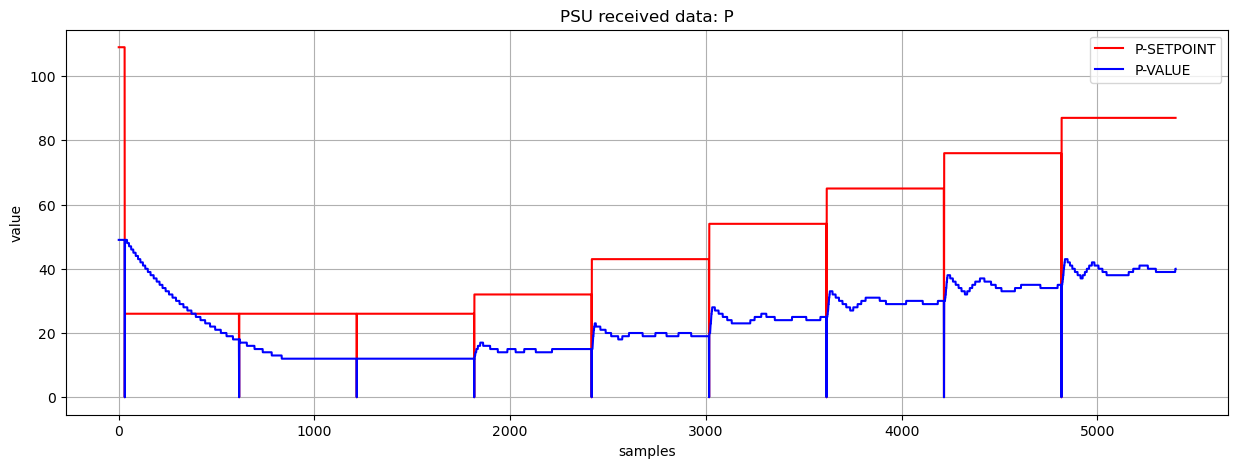

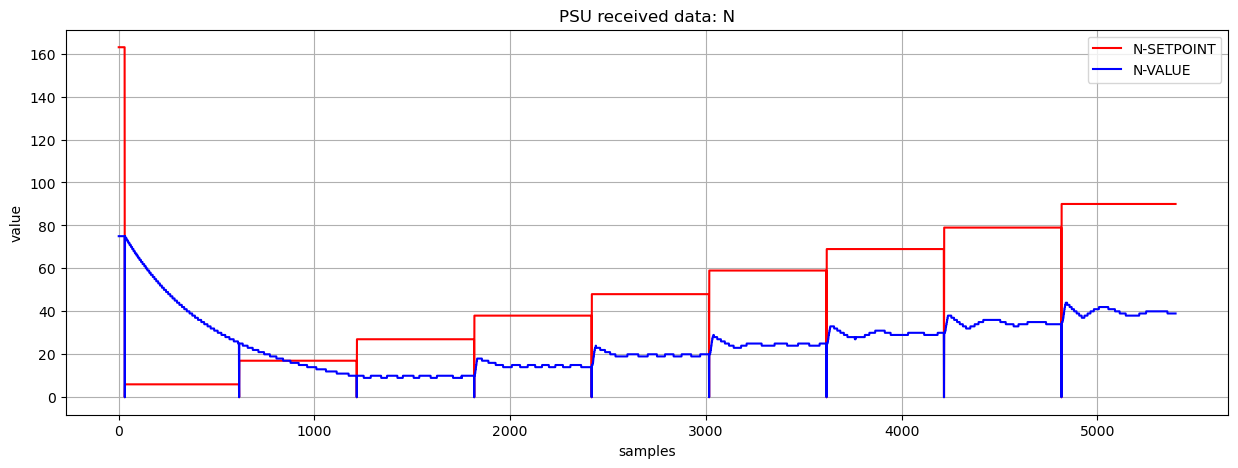

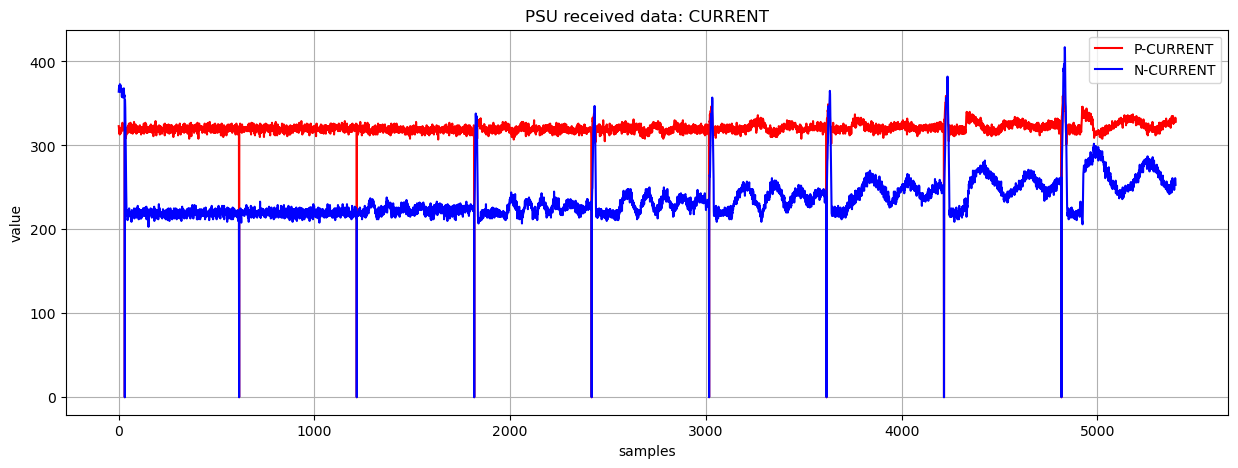

In [18]:
# P-SETPOINT & P-VALUE
df_psu.plot(
    title="PSU received data: P",
    y=['P-SETPOINT', 'P-VALUE'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# N-SETPOINT & N-VALUE
df_psu.plot(
    title="PSU received data: N",
    y=['N-SETPOINT', 'N-VALUE'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# P-CURRENT & N-CURRENT
df_psu.plot(
    title="PSU received data: CURRENT",
    y=['P-CURRENT', 'N-CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

# B) READ PG DATA IN A LOOP

In [19]:
PG_TYPE_DATASTART = 0x1000
PG_TYPE_DATAEND = 0x1001
PG_TYPE_PULSEDATA = 0x1002
PG_TYPE_ZERODATA = 0x1003

In [29]:
pg_pulse_header = ["VOLTAGE", "CURRENT"]
df_pg_pulse = pd.DataFrame(columns=pg_pulse_header)

send_PSU_setpoints(device_serials[0], 45, 45, verbose=0)

for i in range(2000):
    pg_data, pg_datatype, pg_crc_status = read_PG_data(device_serials[1], 0)

    if pg_datatype == PG_TYPE_PULSEDATA:
        # Add a new row to the DataFrame
        new_row = pd.DataFrame(pg_data, columns=pg_pulse_header)
        df_pg_pulse = pd.concat([df_pg_pulse, new_row], ignore_index=True)

    if pg_datatype == PG_TYPE_DATASTART:
        for j in range(1000):    # ADD 100 ZERO DATA ROWS
            zero_row = pd.DataFrame([zerodata], columns=pg_pulse_header)
            df_pg_pulse = pd.concat([df_pg_pulse, zero_row], ignore_index=True)

# CORRECT WITH ZERODATA
df_pg_pulse_corrected = df_pg_pulse.copy()
df_pg_pulse_corrected["VOLTAGE"] = df_pg_pulse_corrected["VOLTAGE"] - zerodata[0]
df_pg_pulse_corrected["CURRENT"] = df_pg_pulse_corrected["CURRENT"] - zerodata[0]

# SCALED TO DISPLAY VOLTAGE
df_pg_pulse_scaled = df_pg_pulse_corrected.copy()
df_pg_pulse_scaled["VOLTAGE"] = df_pg_pulse_scaled["VOLTAGE"] * 0.15
df_pg_pulse_scaled["CURRENT"] = df_pg_pulse_scaled["CURRENT"] * 0.15

#df_pg_pulse

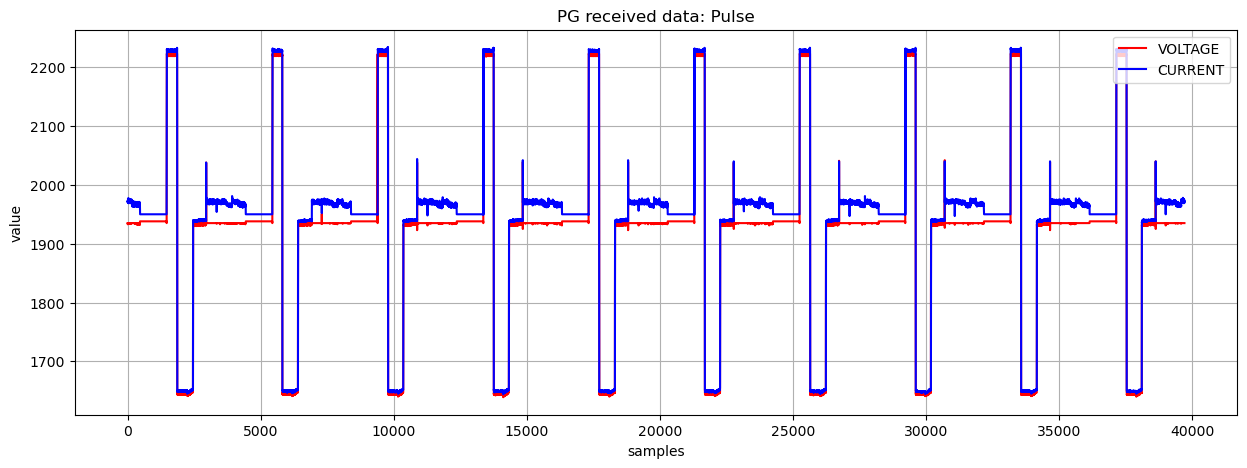

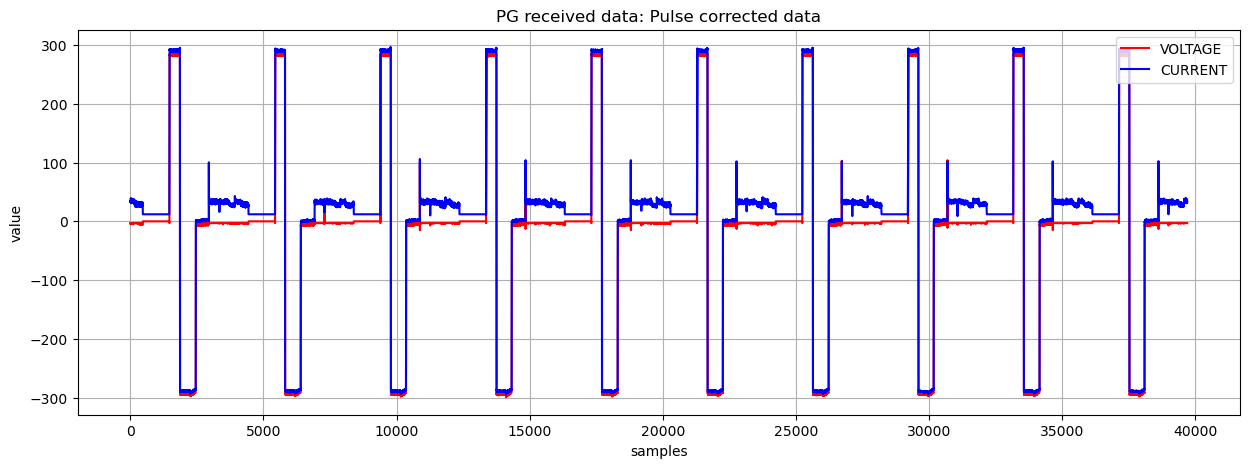

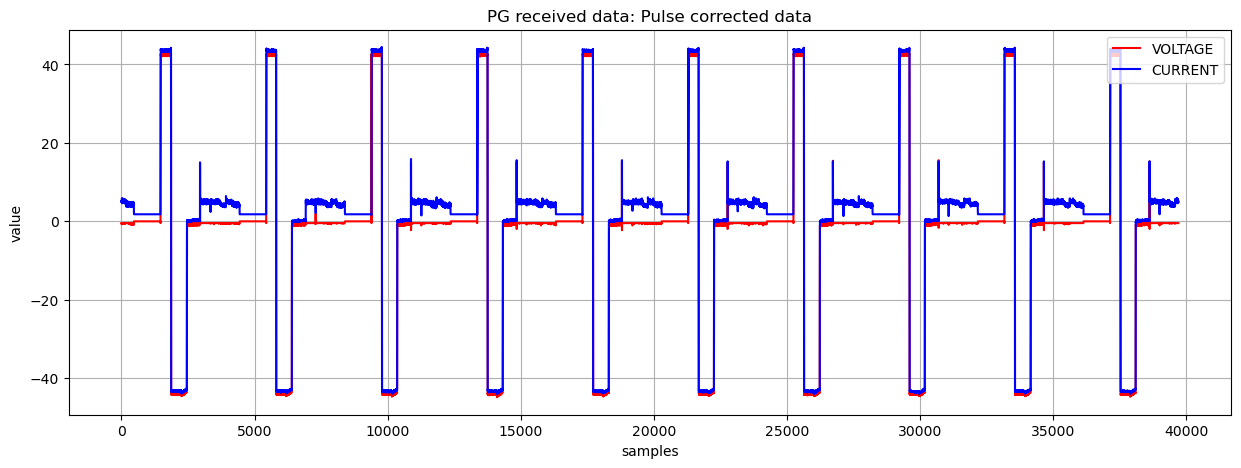

In [30]:
# CURRENT & VOLTAGE
df_pg_pulse.plot(
    title="PG received data: Pulse",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE CORRECTED (zerodata)
df_pg_pulse_corrected.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE SCALED
df_pg_pulse_scaled.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()

# READ NEXT PULSE TEST

In [39]:
pg_singlepulse_header = ["VOLTAGE", "CURRENT"]
df_pg_singlepulse = pd.DataFrame(columns=pg_singlepulse_header)

send_PSU_setpoints(device_serials[0], 45, 45, verbose=0)

pg_data, _ = read_next_PG_pulse(device_serials[1])

new_row = pd.DataFrame(pg_data, columns=pg_singlepulse_header)
df_pg_singlepulse = pd.concat([df_pg_singlepulse, new_row], ignore_index=True)


# CORRECT WITH ZERODATA
df_pg_singlepulse_corrected = df_pg_singlepulse.copy()
df_pg_singlepulse_corrected["VOLTAGE"] = df_pg_singlepulse_corrected["VOLTAGE"] - zerodata[0]
df_pg_singlepulse_corrected["CURRENT"] = df_pg_singlepulse_corrected["CURRENT"] - zerodata[0]

# SCALED TO DISPLAY VOLTAGE
df_pg_singlepulse_scaled = df_pg_singlepulse_corrected.copy()
df_pg_singlepulse_scaled["VOLTAGE"] = df_pg_singlepulse_scaled["VOLTAGE"] * 0.15
df_pg_singlepulse_scaled["CURRENT"] = df_pg_singlepulse_scaled["CURRENT"] * 0.15

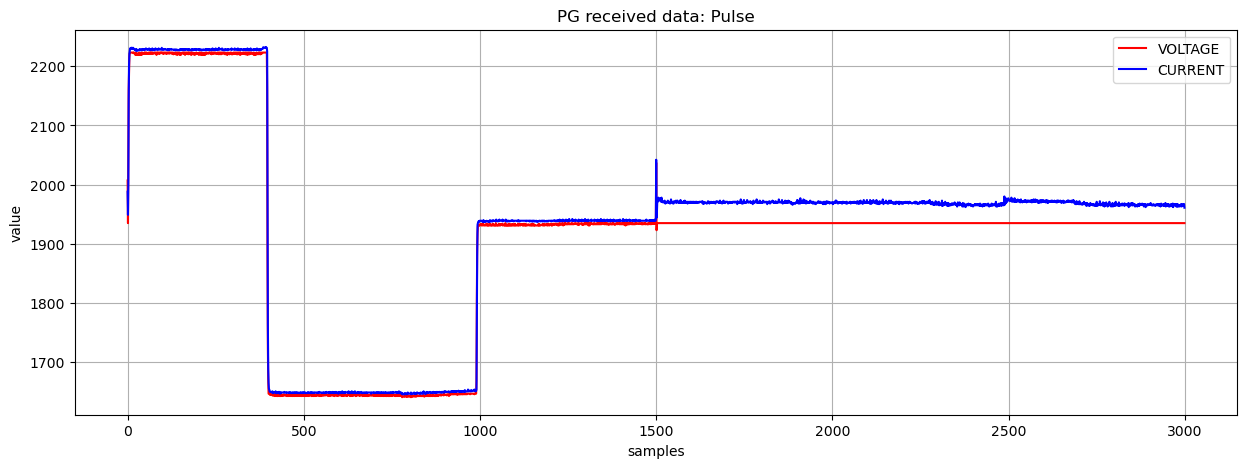

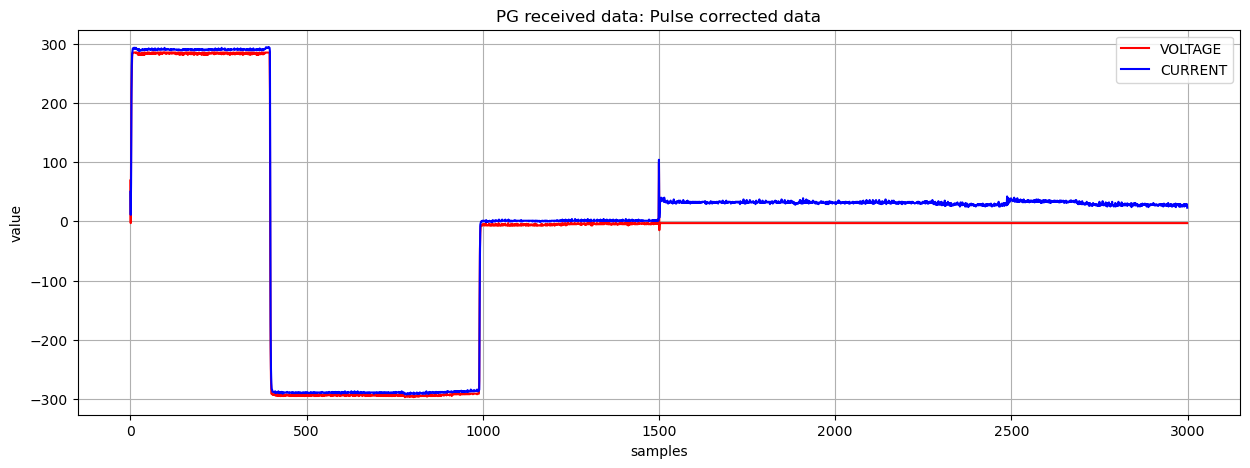

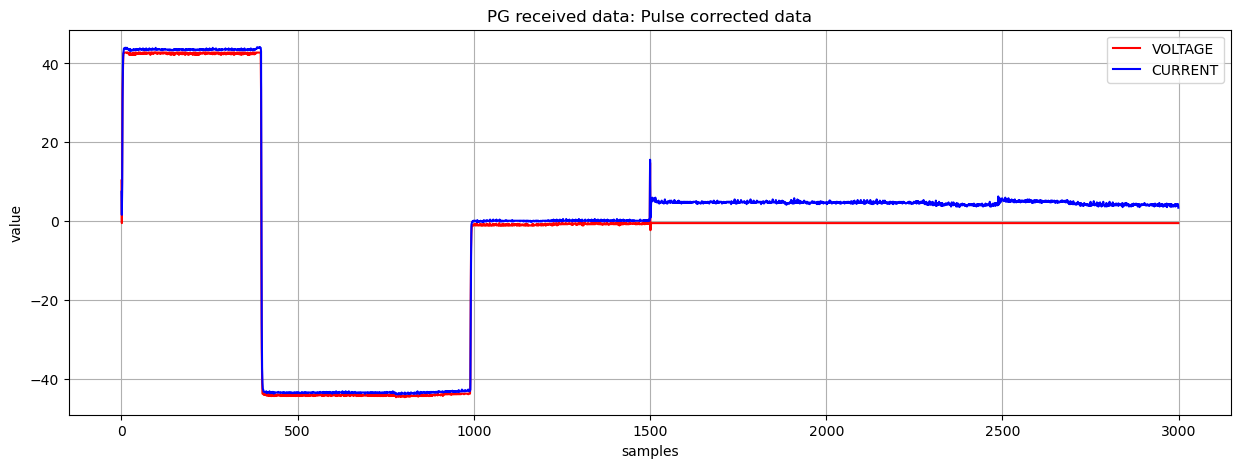

In [40]:
# CURRENT & VOLTAGE
df_pg_singlepulse.plot(
    title="PG received data: Pulse",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE CORRECTED (zerodata)
df_pg_singlepulse_corrected.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()


# CURRENT & VOLTAGE SCALED
df_pg_singlepulse_scaled.plot(
    title="PG received data: Pulse corrected data",
    y=['VOLTAGE', 'CURRENT'],
    figsize=(15,5),
    color=['red', 'blue'],
    style=['-', '-'],
    grid=True,
    )
plt.xlabel('samples')
#plt.xlabel('time [ms]')
plt.ylabel('value')
plt.show()